In [36]:
import quimb.tensor as qtn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [30]:
N = 10
circ = qtn.Circuit(N)

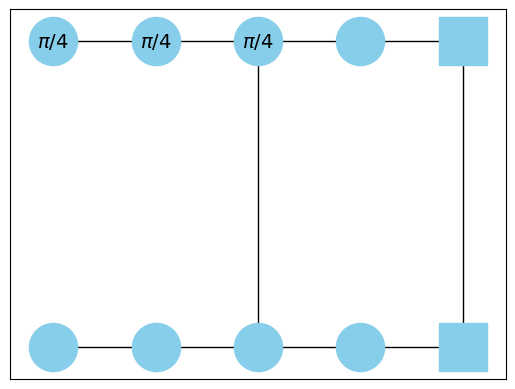

In [37]:
# Make the graph of the qubits
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (5, 6), (6, 7), (7, 8), (8, 9), (2, 7), (4, 9)]
G = nx.Graph(edges)

# Position the nodes
pos = {
    0: (0, 0),
    1: (1, 0),
    2: (2, 0),
    3: (3, 0),
    4: (4, 0),
    5: (0, -1),
    6: (1, -1),
    7: (2, -1), 
    8: (3, -1),
    9: (4, -1),
}

# Draw the graph
subset_b = [4, 9]
subset_c = [0, 1, 2, 3, 5, 6, 7, 8]
custom_labels = {0:"$\\pi$/4", 1:"$\\pi$/4", 2:"$\\pi$/4", 3:"", 4:"", 5:"", 6:"", 7:"", 8:"", 9:""}
nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=14, font_color='black')
nx.draw_networkx_nodes(G, pos, nodelist=subset_b, node_shape='s', node_color='skyblue', node_size=1200)
nx.draw_networkx_nodes(G, pos, nodelist=subset_c, node_shape='o', node_color='skyblue', node_size=1200)

# Draw edges and labels (optional)
nx.draw_networkx_edges(G, pos)
#nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=500)

# Display the plot
plt.show()

In [31]:
def brickwork_state_init(qtm_circ):
    for i in [1, 2, 3, 4, 6, 7, 8, 9]:
        qtm_circ.apply_gate('H', i)
    # create the entanglement for the brickwork state
    circ.apply_gate('CZ', 0, 1)
    circ.apply_gate('CZ', 1, 2)
    circ.apply_gate('CZ', 2, 3)
    circ.apply_gate('CZ', 3, 4)
    
    circ.apply_gate('CZ', 5, 6)
    circ.apply_gate('CZ', 6, 7)
    circ.apply_gate('CZ', 7, 8)
    circ.apply_gate('CZ', 8, 9)

    circ.apply_gate('CZ', 2, 7)
    circ.apply_gate('CZ', 4, 9)
    return qtm_circ


In [32]:
circ.apply_gate('X',0)
circ.apply_gate('X',5)
circ = brickwork_state_init(circ)

In [33]:
# Build the projector on the plus state to deterministically "simulate" measurement of the plus state 

hadamard_zeroket_zerobra_hadamard = np.matmul(np.matmul(np.array([[1, 1], [1,-1]]), np.array([[1, 0], [0,0]])), np.array([[1, 1], [1,-1]]))
proj = 1/2 * hadamard_zeroket_zerobra_hadamard

def rotation_z_gate(theta):
    rot_z = np.array([[np.exp(-1j*theta), 0],[0, np.exp(1j*theta)]])
    return rot_z

def z_rot_proj_meas(qubit, theta, qtm_circ):
    # Rotate qubit to be measured
    z_rot = rotation_z_gate(theta)
    qtm_circ.apply_gate(z_rot, qubit)
    
    # Apply the "measurement" projector
    qtm_circ.apply_gate(proj, qubit)

    # Reormalize the state
    state_vector = np.round(qtm_circ.psi.to_qarray(), 10)
    ## Compute renormalization factor from the norm of the vector after projective measurement
    renorm_factor = np.sqrt(np.dot(state_vector.conj().T, state_vector))
    ## Apply renormalization with identity matrix on measured qubit
    renorm_matrix = np.array([[1, 0], [0, 1]])* 1/renorm_factor
    qtm_circ.apply_gate(renorm_matrix, qubit)

In [34]:
z_rot_proj_meas(0, np.pi/4, circ)
z_rot_proj_meas(5, 0, circ)
z_rot_proj_meas(1, np.pi/4, circ)
z_rot_proj_meas(6, 0, circ)
z_rot_proj_meas(2, np.pi/4, circ)
z_rot_proj_meas(7, 0, circ)
for qubit in [3, 8]:
    z_rot_proj_meas(qubit, 0, circ)

In [35]:
#for i in range(10):
    #circ.apply_gate('H', i)
for i in [0, 5, 1, 6, 2, 7, 3, 8]:
    circ.apply_gate('H', i)

list = np.nonzero(np.round(circ.psi.to_qarray(), 10))

sv =np.round(np.exp(-3j * np.pi/2)*circ.psi.to_qarray(), 10)
print(list[0], len(sv))
for i in list[0]:
    print(sv[i])

[ 1 33] 1024
[0.707107+0.j]
[-0.707107+0.j]
